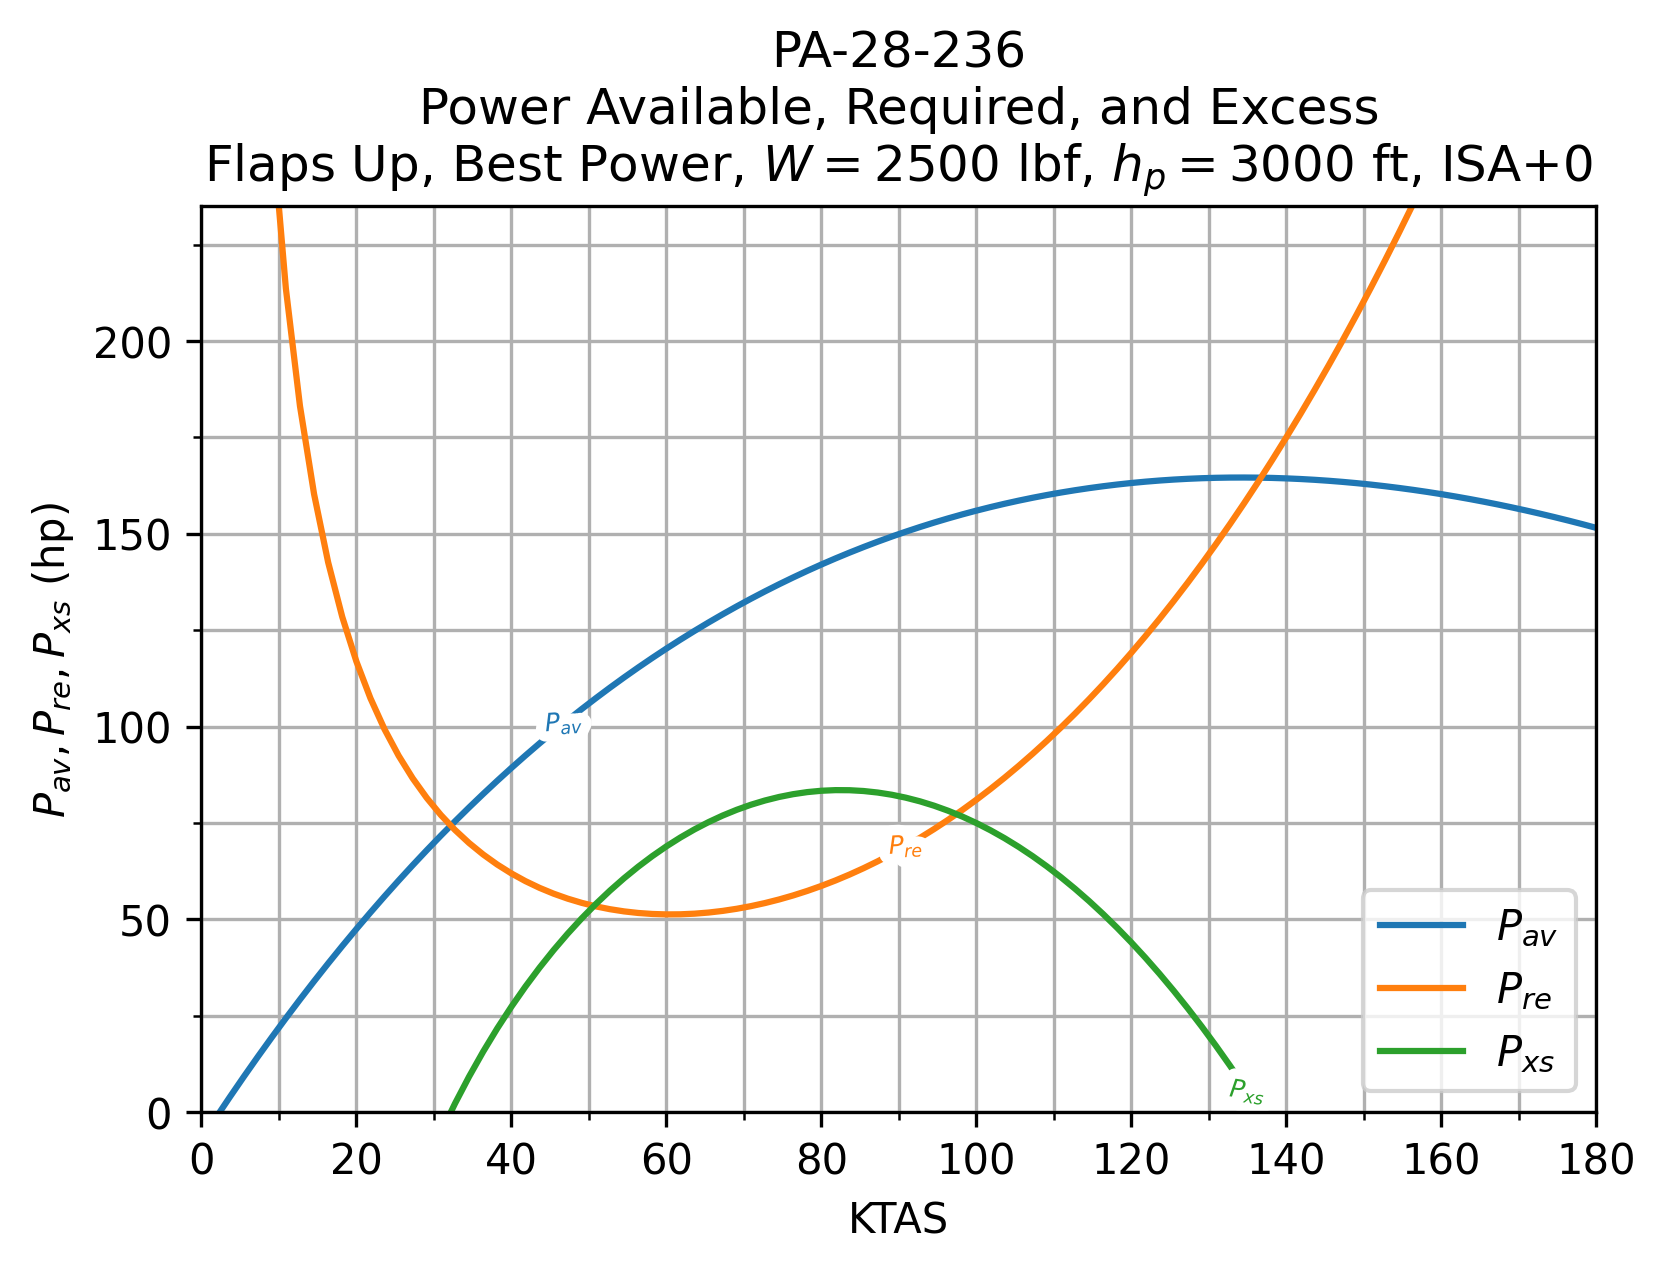

In [3]:
%reload_ext autoreload
%autoreload 2

from labellines import labelLines
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

from the_bootstrap_approach.conditions import FullThrottleConditions
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.propeller_chart import propeller_efficiency

from n51sw_dataplate import N51SW

operating_conditions = FullThrottleConditions(
    N51SW, 2500, 3000, british_standard_temperature(3000), Mixture.BEST_POWER, 2400
)

fig, ax = plt.subplots()

# $V_{NE}$ for a Piper Dakota is 171 KIAS.
never_exceed_speed = tas(171, operating_conditions.relative_atmospheric_density)
# Round up to the nearest 10 KTAS.
never_exceed_speed = int(math.ceil(never_exceed_speed / 10.0)) * 10
ktas = np.linspace(0, never_exceed_speed, 100)[1:]

p_av = (
    power_available(
        propeller_efficiency(
            sdef_t(N51SW.z_ratio),
            propeller_advance_ratio(
                kn_to_fts(ktas),
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            propeller_power_coefficient(
                operating_conditions.power,
                operating_conditions.atmospheric_density,
                operating_conditions.propeller_rps,
                N51SW.propeller_diameter,
            ),
            power_adjustment_factor_x(N51SW.total_activity_factor),
        ),
        operating_conditions.power,
    )
    # 1 hp is the ability to apply 550 ft-lbf/s.
    / 550
)
ax.plot(ktas, p_av, label=r"$P_{av}$")

p_re = (
    power_required(operating_conditions.g, operating_conditions.h, kn_to_fts(ktas))
    / 550
)
ax.plot(ktas, p_re, label=r"$P_{re}$")

p_xs = p_av - p_re
ax.plot(ktas, p_xs, label=r"$P_{xs}$")

labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=6)

ax.set(
    xlabel="KTAS",
    ylabel=r"$P_{av}, P_{re}, P_{xs}$ (hp)",
    title=(
        "PA-28-236\n"
        "Power Available, Required, and Excess\n"
        f"{N51SW.configuration}, "
        f"{operating_conditions.mixture.value}, "
        f"$W = {operating_conditions.gross_aircraft_weight}$ lbf, "
        f"$h_p = {operating_conditions.pressure_altitude}$ ft, "
        f"ISA{0:+}"
    ),
)

ax.grid(True, which="both")

ax.xaxis.set_minor_locator(AutoMinorLocator((2)))
ax.yaxis.set_minor_locator(AutoMinorLocator((2)))

ax.set_xlim([0, never_exceed_speed])
ax.set_ylim([0, N51SW.rated_full_throttle_engine_horsepower])

plt.legend()

fig.set(dpi=300)
plt.show()